In [23]:
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Import training data: Amazon benchmark, with additional neutral reviews
data = pd.read_csv('/content/preprocessed.csv', index_col=[0])
data.head()

,text,Sentiment
0,good price return,1
1,device work advertise like size,1
2,looks good battery suck phone arrive appear pr...,0
3,like new excellent condition,1
4,battery disappointment take time get use phone...,0


In [28]:
# Load the spacy model
nlp = spacy.load('en_core_web_sm')

# Define a function to extract named entities
def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities


# Apply the function to the 'text' column
df['entities'] = df['text'].apply(extract_entities)

# View the results
df.head()


,text,Sentiment,entities
0,good price return,1,[]
1,device work advertise like size,1,[]
2,looks good battery suck phone arrive appear pr...,0,"[(two year old, DATE), (12, CARDINAL), (80, CA..."
3,like new excellent condition,1,[]
4,battery disappointment take time get use phone...,0,"[(phone11, GPE), (400, CARDINAL), (10 hr night..."


In [17]:
X = data['text'].values
y = data['Sentiment'].values

# Split the dataset into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the base models
lr_model = make_pipeline(TfidfVectorizer(), LogisticRegression())
dt_model = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())
nb_model = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Generate predictions
lr_pred = cross_val_predict(lr_model, X_val, y_val, cv=5, method='predict_proba')[:,1]
dt_pred = cross_val_predict(dt_model, X_val, y_val, cv=5, method='predict_proba')[:,1]
nb_pred = cross_val_predict(nb_model, X_val, y_val, cv=5, method='predict_proba')[:,1]

# Define the meta-model
meta_model = LogisticRegression()

# Define the stack ensemble model
ensemble_model = StackingClassifier(
    estimators=[('lr', lr_model), ('dt', dt_model), ('nb', nb_model)],
    final_estimator=meta_model,
    cv=5
)

# Train the stack ensemble model on the training set
ensemble_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ensemble_model.predict(X_test)

# Evaluate the performance of the ensemble model
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

# Print the classification report
report = classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive'])

print(report)

# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns



Accuracy: 0.7472035794183445
              precision    recall  f1-score   support

    Negative       0.74      0.77      0.75       180
     Neutral       0.00      0.00      0.00        43
    Positive       0.75      0.88      0.81       224

    accuracy                           0.75       447
   macro avg       0.50      0.55      0.52       447
weighted avg       0.68      0.75      0.71       447

[[138   0  42]
 [ 20   0  23]
 [ 28   0 196]]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[138,   0,  42],
       [ 20,   0,  23],
       [ 28,   0, 196]])

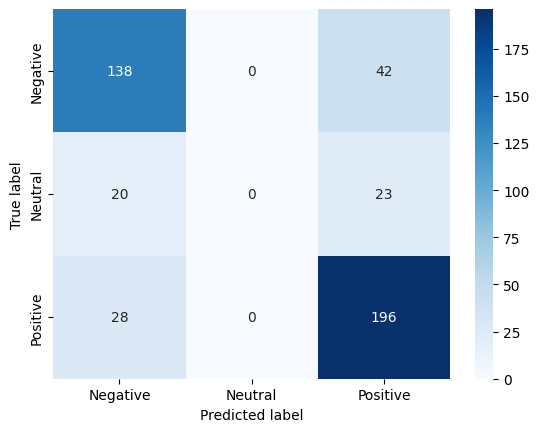

In [22]:
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()